In [1]:
#%load_ext rpy2.ipython
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['legend.numpoints'] = 1
from IPython.display import clear_output
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
sns.set_style(style='white')
import pandas as pd
import NCITerminology as NCIT
import sharedVariable as shv
from matplotlib.lines import Line2D
import networkx as nx
import numpy as np
from scipy.cluster.hierarchy import cut_tree
%matplotlib inline
plotOutDir='/cellar/users/btsui/Documents/Skymap/Figures/'
from scipy.stats import f_oneway
from skimage.filters import threshold_otsu
#from skimage.filters import threshold_otsu
from scipy.stats import spearmanr
import re
import matplotlib.pyplot as plt


In [18]:
NCIT= reload(NCIT)


###  paramters



In [2]:
ensgToSymbolDir='/cellar/users/btsui/Data/nrnb01_nobackup/METAMAP/ensgToSymbol.csv'

rawAnnotSrsDir='../../Parsing/allSRS.pickle'
devStageTagRegex="(?:dev[a-z_\- ]+stage)|(?:^age$)"
ignoreSpatialList=['Cardiac Ventricle'] #The term Heart Ventricle is often  confounded with Brain Ventricle 
mySpecie='mmGRC38'

In [3]:
RunLabel=u'Run'

In [4]:
rawAnnotation=pd.read_pickle(rawAnnotSrsDir)

### load in NLP terms extracted from raw annotations

None the less, we can use the NLP extracted tissue labels

In [5]:
percentageAlgnThreshold=0.5
studyLabel='Study'
metamapScore=500
mappingDfDirFormat='../InData/normalTissueMappingDf/data.{metamapScore}.csv'
inputAnnotDf_OutDir=mappingDfDirFormat.format(metamapScore=metamapScore)

In [6]:
sra_dump_dir='/cellar/users/btsui/Project/METAMAP/notebook/Parsing/sra_dump.csv'

In [7]:
sra_dump=pd.read_csv(sra_dump_dir)

/cellar/users/btsui/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,6,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
!ls /cellar/users/btsui/Data/nrnb01_nobackup/Data/SRA/MATRIX/DATA/mmGRC38/allSRAmatrix.realign.gene.hgnc.npy

/cellar/users/btsui/Data/nrnb01_nobackup/Data/SRA/MATRIX/DATA/mmGRC38/allSRAmatrix.realign.gene.hgnc.npy


In [9]:
rawSraDf=shv.loadDf('/cellar/users/btsui/Data/nrnb01_nobackup/Data/SRA/MATRIX/DATA/{mySpecie}/allSRAmatrix.realign.gene.hgnc'.format(mySpecie=mySpecie))
myAlgnStatDirFormat='/cellar/users/btsui/Data/nrnb01_nobackup/METAMAP/{genome}.percent_aligned.pyc'
myAlgnStat=pd.read_pickle(myAlgnStatDirFormat.format(genome=mySpecie))
passingQualitySrr=myAlgnStat.index[myAlgnStat>percentageAlgnThreshold]
sraDf=rawSraDf.loc[:,passingQualitySrr]

### initilize NLP

load in prefilered tissue terms

In [10]:
inputAnnotDf=pd.DataFrame.from_csv(inputAnnotDf_OutDir)

/cellar/users/btsui/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (13,14,33,34) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [11]:
blackListMask=inputAnnotDf.NciEng.isin(ignoreSpatialList)
inputAnnotDf['blacklisted']=blackListMask

### initilize ontology 
take only subset of edges: is_a, and part of

In [13]:
#import networkx as nx
#nx.from_pandas_edgelist()

In [19]:
onto=NCIT.NCITerminology()
is_a_rels=onto.relToEng[onto.relToEng.str.lower().str.contains('has[\w_]+_parent')].index.tolist()+['is_a','R82']
onto.setCellOntoEdgeSubset(is_a_rels)

In [20]:
nodeToEngMapping=onto.cleanedIdS.copy()
rootName='Thing'
nodeToEngMapping.loc['root_node']=rootName
engG=nx.relabel_nodes(G=onto.cellOntoSubset,mapping=nodeToEngMapping)
revEngG=engG.reverse()

### temporal time extraction from raw annotations

Unfortunately, majority of the mouse developement annotatioe time unit cannot be easily extraced from. 

On the bright side, regex does the job os extracting the timeline pretty well.

In [21]:
withSeqAnnot=rawAnnotation

subSpecieDf=inputAnnotDf[inputAnnotDf.ScientificName=='Mus musculus']

m1=rawAnnotation.index.get_level_values(0).isin(subSpecieDf.srs)
mouseBaseSubset=rawAnnotation[m1]
m2=(mouseBaseSubset.index.get_level_values(1).str.contains(devStageTagRegex,case=False))
tmpDevAttribSubset=mouseBaseSubset[m2].str.lower()

mouseBaseDevAttribSubsetS=pd.Series(index=tmpDevAttribSubset.index.get_level_values(0), 
          data=tmpDevAttribSubset.values)
#impute 
#mouseBaseDevAttribSubsetS=mouseBaseDevAttribSubsetS.str.replace('adult','8 week')
timePeriod={'e':'(?:e[^a-zA-Z\d\s:]?\d+)|(?:embry)|(?:dpc)',
            'p':'(?:p[^a-zA-Z\d\s:]?\d+)|(?:post.?natal)|(?:dpp)'
            ,'q':'(?:week)'
           ,'r':'(?:month)'
           ,'s':'(?:year)'}
#do a 
prefixFormat='([{prefixes}])\d+'
myPrefixStr=prefixFormat.format(prefixes=''.join(timePeriod.keys()))

In [22]:
#myPrefixStr.head()

### extract infomation

In [23]:
myPrefixExtractList=[]
for prefix,myRegex in timePeriod.iteritems():
    myTmpSubS=mouseBaseDevAttribSubsetS[mouseBaseDevAttribSubsetS.str.contains(myRegex)].copy()
    myTmpSubS[:]=prefix
    myPrefixExtractList.append(myTmpSubS)
periodExtract=pd.concat(myPrefixExtractList)
allDigitExtract=mouseBaseDevAttribSubsetS.str.extract('(\d+)').dropna().astype(np.int)
ageCap=1000000
digitExtract=allDigitExtract[allDigitExtract<ageCap]
srsToEmbryonicDayS=(periodExtract+digitExtract.astype(np.str)).dropna()

/cellar/users/btsui/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  import sys


In [24]:
#srsToEmbryonicDayS.head()

### start binning

In [25]:
dayMappingS=srsToEmbryonicDayS.unique()

In [26]:
dayToBinDay=pd.Series(index=dayMappingS,data=dayMappingS).sort_values()
myRegexDict={'p00-5 days':'p[0-5]$',
             'p06-9 days':'p[6-9]$',
             'p10-19 days':'p1[0-9]$',
             'p20-29 days':'p2[0-9]$',
             'p30-99 days':'p[3-7][0-9]',
            'p100- days':'p[0-9][0-9][0-9]'}
mySList=[]
for myVal,myRegex in myRegexDict.iteritems():
    myI=dayToBinDay[dayToBinDay.str.contains(myRegex)].values
    myD=[myVal]*len(myI)
    tmpS=pd.Series(index=myI,data=myD)
    mySList.append(tmpS)
specialMapping=pd.concat(mySList)

In [27]:
preFilterSrsToBinDayS=srsToEmbryonicDayS.copy()
convertingSrsToAnnot=srsToEmbryonicDayS[srsToEmbryonicDayS.isin(specialMapping.index)]
#preFilterSrsToBinDayS.loc[convertingSrsToAnnot.index]=specialMapping.loc[convertingSrsToAnnot.values].values

In [28]:
srsToBinDayS=convertingSrsToAnnot#preFilterSrsToBinDayS.groupby(preFilterSrsToBinDayS.index).first()

# query

In [29]:
srsToEmbryonicDayS=srsToEmbryonicDayS.groupby(srsToEmbryonicDayS.index).first()

In [30]:
##dev data: srsToBinDayS
devTimeS=srsToEmbryonicDayS

In [31]:
queryAnnotDf=inputAnnotDf.copy()

In [32]:
##get embryonic tissues
myParentNciNode='Embryonic Structure or System'
myChildrenCellTypes=nx.ego_graph(G=revEngG,n=myParentNciNode,radius=10000).nodes()
targetCellTypes=myChildrenCellTypes

In [33]:
### if dev time, always take dev 
queryAnnotDf['Embryo']=queryAnnotDf.NciEng.isin(targetCellTypes)

In [34]:
queryAnnotDf['DevTime']=devTimeS.loc[inputAnnotDf.srs].values

In [35]:
#get matrix 
#w_DevTimeUnitDf=queryAnnotDf[queryAnnotDf.DevTime.notnull()]
#
m1=(queryAnnotDf.DevTime.isnull()&queryAnnotDf.NciEng.isin(targetCellTypes))
m2=queryAnnotDf.DevTime.notnull()
m3=~queryAnnotDf.blacklisted
m4=queryAnnotDf.Run.isin(sraDf.columns)
hitDf=queryAnnotDf[(m1|m2)&m3&m4
                             ]
#


In [36]:
VC=hitDf.Run.value_counts()
uniqueTerm_Runs=VC#.index[VC==1]
uniqueHitDf=hitDf#[hitDf.Run.isin(uniqueTerm_Runs)]
uniqueHitDf['DevTime']=uniqueHitDf['DevTime'].fillna('na')

/cellar/users/btsui/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


### check data

### data cleaning

In [37]:
uniqueHitDf.loc[uniqueHitDf.NciEng=='Zygote','DevTime']='e0'
uniqueHitDf.loc[uniqueHitDf.NciEng=='Morula','DevTime']='e3'
uniqueHitDf.loc[uniqueHitDf.NciEng=='Cardiomyocyte','NciEng']='Heart'
uniqueHitDf.loc[uniqueHitDf.NciEng=='Fetal Liver','NciEng']='Hepatic Tissue'

uniqueHitDf.loc[uniqueHitDf.NciEng=='Small Intestinal Wall Tissue','NciEng']='Small Intestine'
uniqueHitDf.loc[uniqueHitDf.NciEng=='Hepatocyte','NciEng']='Hepatic Tissue'

withTimeUnitDf=uniqueHitDf[uniqueHitDf.DevTime!='na']

/cellar/users/btsui/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [38]:
#m=uniqueHitDf.NciEng.str.contains('Liver',case=False)
#uniqueHitDf.NciEng.value_counts().head()

In [39]:
withTimeUnitDf['Period']=withTimeUnitDf.DevTime.str.extract('([qrspe])').values
withTimeUnitDf['Digit']=withTimeUnitDf.DevTime.str.extract('[qrspe](\d+)').astype(np.int).values

/cellar/users/btsui/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """Entry point for launching an IPython kernel.
/cellar/users/btsui/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/cellar/users/btsui/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  
/cell

In [40]:
#withTimeUnitDf[withTimeUnitDf.NciEng.str.contains('Primordial')]

In [41]:
"""
            ,'q':'(?:week)'
           ,'r':'(?:month)'
           ,'s':'(?:year)'}
"""
m=withTimeUnitDf.DevTime.str.contains('^e')
withTimeUnitDf.loc[m,'True_Time']=withTimeUnitDf.loc[m,'Digit']
m=withTimeUnitDf.DevTime.str.contains('^p')
withTimeUnitDf.loc[m,'True_Time']=withTimeUnitDf.loc[m,'Digit']+18.0
m=withTimeUnitDf.DevTime.str.contains('^q')
withTimeUnitDf.loc[m,'True_Time']=withTimeUnitDf.loc[m,'Digit']*7+18.0
m=withTimeUnitDf.DevTime.str.contains('^r')
withTimeUnitDf.loc[m,'True_Time']=withTimeUnitDf.loc[m,'Digit']*30+18.0
m=withTimeUnitDf.DevTime.str.contains('^s')
withTimeUnitDf.loc[m,'True_Time']=withTimeUnitDf.loc[m,'Digit']*365.5+18.0

/cellar/users/btsui/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


In [42]:
myImportantCol=['NciEng','Period','Digit','srp','True_Time','DevTime']
mySubDF=withTimeUnitDf.sort_values(['NciEng','True_Time']).drop_duplicates(myImportantCol)[myImportantCol]

In [43]:
mySubDF['I']=np.arange(0,mySubDF.shape[0])

In [44]:
VC=mySubDF.NciEng.value_counts()

In [45]:
hierachyGraph=[('Zygote','Morula'),
               ('Morula','Blastocyst'),
('Blastocyst','Epiblast'),
               ('Epiblast','Skin'),
 ('Epiblast','Mesoderm'),
 ('Epiblast','Neural Tube'),
 ('Neural Tube','Brain'),
 ('Neural Tube','Spinal Cord'),
    ('Mesoderm','Heart'),
    ('Mesoderm','Testis'),
    ('Brain','Hippocampus'),
    ('Brain','Neuron'),
    ('Brain','Cortical Cell Layer of the Cerebellum')     ,      
    ('Brain','Hypothalamus'),
               ('Mesoderm','Renal Tissue'),
    ('Blastocyst','Endoderm'),
    ('Endoderm','Pancreas'),
    ('Endoderm','Lung Tissue'),
    ('Mesoderm','Chondrocyte'),
    ('Endoderm','Hepatic Tissue'),
    ('Mesoderm','Hematopoietic Stem Cell'),
        ('Hematopoietic Stem Cell','Macrophage',),
               ('Endoderm','Thymic Tissue'),
               ('Hematopoietic Stem Cell','B-Lymphocyte'),
               ('Hematopoietic Stem Cell','CD4-Positive T-Lymphocyte'),
        ('Epiblast','Retina'),
        ('Endoderm','Colon'),
        ('Mesoderm','Splenic Tissue'),
        ('Brain','Cerebral Cortex'),
       ("Brain","Corpus Striatum"),
("Brain","Neuron"),
#("Mesoderm","Bone Marrow"),
("Brain","Frontal Lobe"),
    ("Mesoderm","Ovary"),
("Mesoderm","Lens"),
('Pancreas','Beta Cell'),
    ('Pancreas',"Islet of Langerhans"),
('Hematopoietic Stem Cell',"Microglia"),
("Brain","Forebrain"),
("Blastocyst","Primordial Germ Cell"),
("Mesoderm","Adipocyte"),
("Forebrain","Olfactory Bulb"),
("Endoderm","Jejunum"),
("Endoderm","Gastric Tissue"),
("Brain","Corpus Callosum"),
('Endoderm','Small Intestinal Wall Tissue')        
]
CT_root='Zygote'
componentG=nx.from_edgelist(hierachyGraph,create_using=nx.Graph())
componentG_directed=nx.from_edgelist(hierachyGraph,create_using=nx.DiGraph())
componentTraversalOrder=list(nx.dfs_preorder_nodes(componentG,source=CT_root))

In [46]:
testSubsetNcis=componentG.nodes()
col_order=['NciEng','DevTime','srp','srs','Run']
myDesignDf=withTimeUnitDf.set_index('Run',drop=False)[col_order].sort_values(col_order)

selectedNcis=testSubsetNcis
#posnatalMask=(~myDesignDf.DevTime.str.contains('^p'))
subAnnotDf=myDesignDf[myDesignDf.NciEng.isin(selectedNcis)]


sub_sraDf=sraDf.loc[:,subAnnotDf.index]

def zTransform(df):
    #df.copy()
    return (df-df.mean(axis=0))/df.std(axis=0)

log2Df=np.log2(sub_sraDf+1)

inExpressionDf=log2Df

myMultI=subAnnotDf.set_index(col_order).index
inExpressionDf.columns=myMultI

#mean dev layer
collapse_resolution=['NciEng','DevTime','srp']
collapseDf=inExpressionDf.groupby(level=collapse_resolution, axis=1).mean()

In [47]:
CT_subDf=mySubDF[mySubDF.NciEng.isin(componentG.nodes())]

In [48]:
xSpacing=50
ySpacing=50

In [52]:
"""
code for hirachy layout is copied from stack overflow
https://stackoverflow.com/questions/29586520/can-one-get-hierarchical-graphs-from-networkx-with-python-3
"""
def hierarchy_pos(G, root, width=1., vert_gap = 0.5, vert_loc = 0, xcenter = 0, 
                  pos = None, parent = None):
    '''If there is a cycle that is reachable from root, then this will see infinite recursion.
       G: the graph
       root: the root node of current branch
       width: horizontal space allocated for this branch - avoids overlap with other branches
       vert_gap: gap between levels of hierarchy
       vert_loc: vertical location of root
       xcenter: horizontal location of root
       pos: a dict saying where all nodes go if they have been assigned
       parent: parent of this branch.'''
    if pos == None:
        pos = {root:(xcenter,vert_loc)}
    else:
        pos[root] = (xcenter, vert_loc)
    neighbors = list(G.neighbors(root))
    if parent != None:
        neighbors.remove(parent)
    if len((neighbors))!=0:
        dx = width/len(neighbors) 
        nextx = xcenter - width/2 - dx/2
        for neighbor in neighbors:
            nextx += dx
            pos = hierarchy_pos(G,neighbor, width = dx, vert_gap = vert_gap, 
                                vert_loc = vert_loc-vert_gap, xcenter=nextx, pos=pos, 
                                parent = root)
    return pos
hierachyPos=hierarchy_pos(G=componentG,root=CT_root)
#fig,ax=plt.subplots()
#nx.draw(componentG, pos=hierachyPos, with_labels=True,ax=ax)


In [53]:
#componentG

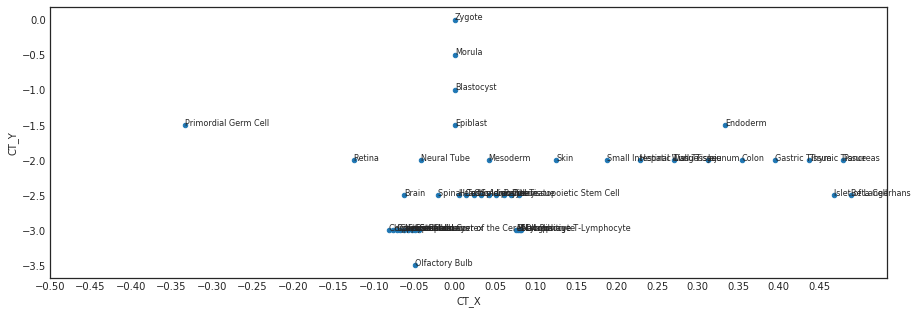

In [54]:
orgi_hierachyPosDf=pd.DataFrame(hierachyPos).T
orgi_hierachyPosDf.columns=['CT_X','CT_Y']
## plot original 
ax=orgi_hierachyPosDf.plot(kind='scatter',x='CT_X',y='CT_Y',figsize=(15,5))
for i, point in orgi_hierachyPosDf.iterrows():
    ax.text(point['CT_X'], point['CT_Y'], str(i),fontdict={'size':8})
ax.set_xticks(np.arange(-0.5,0.5,0.05))
clear_output()

# shifting position of the data

In [55]:
##quick data look up 
myParentNciNode='Hematopoietic Stem Cell'
myChildrenCellTypes=nx.ego_graph(G=componentG,n=myParentNciNode,radius=1).nodes()
myChildrenCellTypes

NodeView(('Hematopoietic Stem Cell', 'Mesoderm', 'Microglia', 'B-Lymphocyte', 'CD4-Positive T-Lymphocyte', 'Macrophage'))

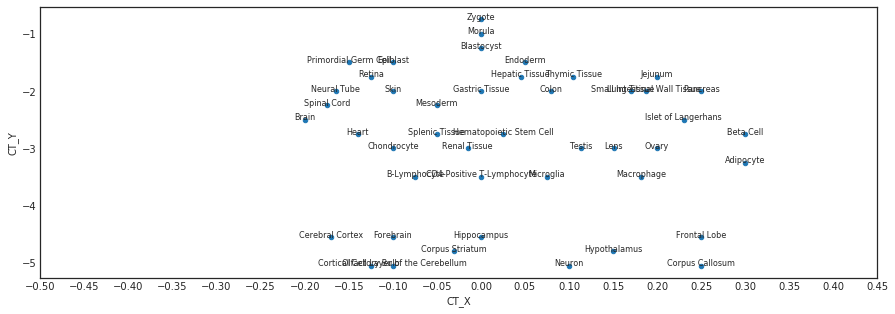

In [56]:


xMapping={'Retina':-0.4,'Hematopoietic Stem Cell':-0.075,'Renal Tissue':-0.15+0.035,
    'Colon':0.1-0.02,'Endoderm':0.15,'Thymic Tissue':0.15-0.045,'Lung Tissue':0.17
          ,'B-Lymphocyte':-0.2+0.025,
         'Splenic Tissue':-0.10-0.1+0.05,'CD4-Positive T-Lymphocyte':-0.1,'Mesoderm':-0.1,
         'Epiblast':-0.1,'Endoderm':0.05,'Retina':-0.31,
          'Neural Tube':-0.25+0.025+0.01,'Brain':-0.25,'Spinal Cord':-0.4+0.15+0.025,
          'Retina':-0.2+0.025,'Skin':-0.4+0.25,
         'Chondrocyte':-0.3+0.125-0.025,'Hepatic Tissue':0+0.05-0.005,
         'Heart':-0.4+0.16,'Primordial Germ Cell':-0.15,u'Jejunum':0.2,'Gastric Tissue':0.,
          'Pancreas':0.25,u'Islet of Langerhans':0.23,'Beta Cell':0.3,
                  'Cerebral Cortex':-0.6+0.4-0.02,
           'Adipocyte':0.2,
          'Ovary':0.1,
          #'Bone Marrow':0.15,
         'Cortical Cell Layer of the Cerebellum':-0.2+0.05,
          "Olfactory Bulb":-0.2+0.025,'Forebrain':-0.2+0.05,
         'Hippocampus':-0.2+0.1,
          'Frontal Lobe':-0.3+0.5,
         'Corpus Callosum':0.2, 'Neuron':0.05, 'Microglia':-0.025,
         'Hypothalamus':0.1,'Hippocampus':-.05}
shiftY=['Spinal Cord','Splenic Tissue','Thymic Tissue','Hepatic Tissue','Jejunum','Retina',
        'Forebrain','Cerebral Cortex' ,'Hippocampus','Frontal Lobe','Hematopoietic Stem Cell','Olfactory Bulb','Heart']
downShifY=['Mesoderm','Beta Cell','Corpus Callosum','Neuron','Cortical Cell Layer of the Cerebellum','Adipocyte']
X_moveBranches={'Epiblast':0.05,'Mesoderm':0.05,}
Y_moveBranches={'Brain':1.8,'Mesoderm':0.5}
yMapping={'Blastocyst':-1.25,'Morula':-1.0,'Zygote':-0.75}#{'Blastocyste':-1.25}
hierachyPosDf=orgi_hierachyPosDf.copy()

for CT, new_location in  xMapping.iteritems():
    hierachyPosDf.loc[CT,'CT_X']=new_location
for CT, new_location in  yMapping.iteritems():
    hierachyPosDf.loc[CT,'CT_Y']=new_location
for CT in shiftY:
    hierachyPosDf.loc[CT,'CT_Y']+=0.25
for CT in downShifY:
    hierachyPosDf.loc[CT,'CT_Y']-=0.25
for branch_CT,offset in X_moveBranches.iteritems():
    chilren=nx.breadth_first_search.bfs_tree(componentG_directed,branch_CT).nodes()
    excludeParentCT=filter(lambda n:n!=branch_CT,chilren)
    hierachyPosDf.loc[excludeParentCT,'CT_X']+=offset
for branch_CT,offset in Y_moveBranches.iteritems():
    chilren=nx.breadth_first_search.bfs_tree(componentG_directed,branch_CT).nodes()
    excludeParentCT=filter(lambda n:n!=branch_CT,chilren)
    hierachyPosDf.loc[excludeParentCT,'CT_Y']-=offset
#shift the position of the nodes
ax=hierachyPosDf.plot(kind='scatter',x='CT_X',y='CT_Y',figsize=(15,5))

for i, point in hierachyPosDf.iterrows():
    ax.text(point['CT_X'], point['CT_Y'], str(i),fontdict={'size':8,'ha':'center'})
ax.set_xticks(np.arange(-0.5,0.5,0.05))
clear_output()

### graph layout

In [57]:
"""

"""
y_component_spacing=6000
x_component_spacing=2000
y_rank_spacing=200
xScale=5

matchedIndexDf=hierachyPosDf.loc[CT_subDf.NciEng]
matchedIndexDf.index=CT_subDf.index
#merge annotation with position DFs
mergedDf=pd.concat( [CT_subDf,matchedIndexDf],axis=1)
mergedDf['Within_CT_Rank']=mergedDf.groupby('NciEng').I.rank()
mergedDf['NODE_Y_LOCATION']=mergedDf['CT_Y']*y_component_spacing-mergedDf['Within_CT_Rank']*y_rank_spacing
mergedDf['I']=np.arange(0,mergedDf.shape[0])
mergedDf['NODE_X_LOCATION']=((mergedDf['I']%2)*xScale+mergedDf['CT_X']*x_component_spacing)
mergedDf['NODE_X_LOCATION_PRESHIFT']=xScale/2+mergedDf['CT_X']*x_component_spacing
mergedDf['Name']=mergedDf.NciEng+'_'+mergedDf.DevTime+'_'+mergedDf.srp

In [58]:
### set node size as sample size
mySrpSizeS=withTimeUnitDf.groupby(['NciEng','DevTime','srp']).size().reset_index(name='n_samples')
srpSizeS=pd.Series(index=mySrpSizeS.NciEng+'_'+mySrpSizeS.DevTime+'_'+mySrpSizeS.srp,
          data=mySrpSizeS.n_samples.values)

In [59]:
fullG=nx.Graph()
fullG.add_nodes_from(mergedDf.Name.values)
X_pos_label='NODE_X_LOCATION'
myPosDf=mergedDf.set_index('Name')[[X_pos_label,'NODE_Y_LOCATION']].copy()
myPosTuple=myPosDf.apply(lambda S:(S.loc[X_pos_label],S.loc['NODE_Y_LOCATION']),axis=1)
X_pos_label='NODE_X_LOCATION_PRESHIFT'
myPosDf=mergedDf.set_index('Name')[[X_pos_label,'NODE_Y_LOCATION']].copy()
myPosTuple_non_shift=myPosDf.apply(lambda S:(S.loc[X_pos_label],S.loc['NODE_Y_LOCATION']),axis=1)



In [65]:

botNodes=mergedDf.sort_values('NODE_Y_LOCATION',ascending=False).groupby('NciEng').last().Name
topNodes=mergedDf.sort_values('NODE_Y_LOCATION',ascending=False).groupby('NciEng').first().Name
### use edges to connect the 
myEdges=[(topNodes.loc[child_CT],botNodes.loc[parent_CT])
for parent_CT,child_CT in 
componentG_directed.in_edges(topNodes.index)]
fullG.add_edges_from(myEdges)

In [66]:
labelPos=myPosDf.copy()
myLabelMapping=labelPos.apply(lambda S:S.name.split('_')[0] if S.name in topNodes.values else '' ,axis=1)

simplifiedMapping=myLabelMapping.copy()
shortFormDict={'B-Lymphocyte':'B-Cell','CD4-Positive T-Lymphocyte':'CD4+\n T-Cell'
              ,'Hematopoietic Stem Cell':'HSC','Primordial Germ Cell':'PGC',
               'Cortical Cell Layer of the Cerebellum':'Cerebellum',
               'Hepatic Tissue':'Liver'
              }
for longForm,shortForm in shortFormDict.iteritems():
    simplifiedMapping=simplifiedMapping.str.replace(longForm,shortForm)
#labelPos
### add lableling for the first node in the
labelPos['NODE_Y_LOCATION']+=600
labelPosTuple=(labelPos).apply(lambda S:(S.loc['NODE_X_LOCATION_PRESHIFT'],S.loc['NODE_Y_LOCATION']),axis=1)

In [67]:
#NCIEng+'_'+DevTime+'_'+srp
withTimeUnitDf['UID']=withTimeUnitDf.NciEng+'_'+withTimeUnitDf.DevTime+'_'+withTimeUnitDf.srp

/cellar/users/btsui/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [69]:
trueTimeLabel='True_Time'
uidToTime=np.log2(withTimeUnitDf.drop_duplicates('UID').set_index('UID')[trueTimeLabel]+1)

# High resolution mouse developmental hierachy map

Aggregating many studies (node) to form a smooth mouse developmental hierachy map. 

Each componenet represent a tissue. Each node represent a particular study at a particular time unit. The color is base on the developmental time extracted from experimental annotation using regex. The node size represent the # of sequencing runs in that particulr time point and study. Each edge represent a differentiate-to or part-of relationship.

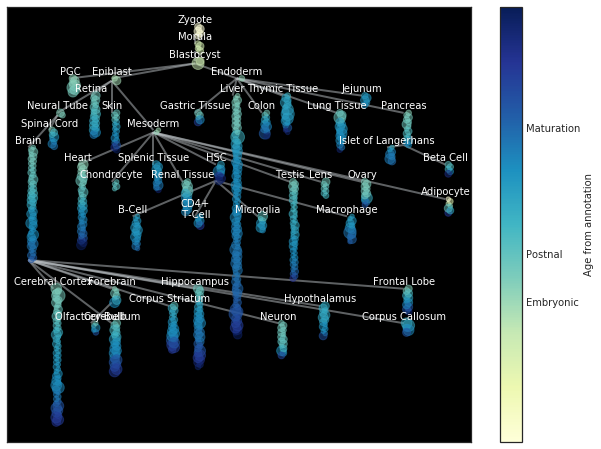

In [86]:
#show the time

#withTimeUnitDf
aspectRatio=1.3
size=8
fig,ax=plt.subplots(figsize=(aspectRatio*size,size))
ax.set_axis_bgcolor('black')

myCmap=mpl.cm.YlGnBu
exprS=uidToTime
#exprS=uidToTime#collapseDf.loc[queryGene]/collapseDf.loc[queryGene].max()
#myI=exprS.index
#exprS.index=myI.get_level_values(0)+'_'+myI.get_level_values(1)+'_'+myI.get_level_values(2).fillna('')

nx.draw_networkx_edges( fullG,pos=myPosTuple_non_shift.to_dict(),
                        with_labels=False,
                       alpha=0.5,edge_color='#BDC3C7',width=2.0,ax=ax)
nx.draw_networkx_labels(fullG,pos=labelPosTuple,labels=simplifiedMapping.to_dict()
                        ,ax=ax,font_color='white',font_size=10)
nx.draw_networkx_nodes( fullG,pos=myPosTuple.to_dict(),cmap=myCmap,node_color=(exprS.loc[list(fullG.nodes())]),
                       node_size=np.log2(srpSizeS.loc[list(fullG.nodes())]+1)*20, with_labels=False,alpha=0.5,ax=ax)

ax.set_xticklabels([])
ax.set_yticklabels([])
##set color bar
"""
#days until mouse embryo maturation: 8
#days until mouse birth: 18
#days until mouse maturation: 4 months and 18 days 
"""
tickPositions=np.log2(np.array([8,18, 4*30+18])+1) 
tickLabels=['Embryonic','Postnal','Maturation']
sm = plt.cm.ScalarMappable(cmap=myCmap, norm=mpl.colors.Normalize(vmin=exprS.min(), vmax=exprS.max()),)
sm._A = []

cax=plt.colorbar(sm,ax=ax)
cax.set_ticks(tickPositions)
cax.set_ticklabels(tickLabels)
cax.set_label('Age from annotation')
fig.savefig(plotOutDir+'heirachy'+'_time.pdf')
fig.savefig(plotOutDir+'heirachy'+'_time.png',dpi=300)

clear_output()

In [87]:
plotOutDir+'heirachy'+'_time.png'

'/cellar/users/btsui/Documents/Skymap/Figures/heirachy_time.png'

# overlay gene expression leve as color

Tp53 is expression known to be tightly regulated in development.
Let's look at the expression level of Tp53. It is upregulated in early stages across many tissues.

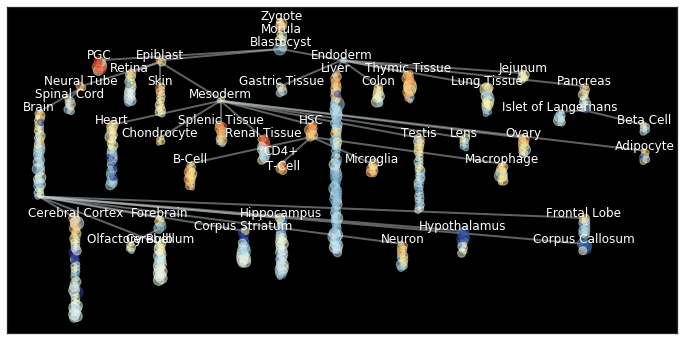

In [84]:
queryGene='Trp53'#'Idh2'#'Idh1'#'Egfr'#'Magea3'#'Mage-a',Hand1,'Sox7','Sox2' 'Nkx2-5'#'Nt5e'#'Idh1'#'Igfbp2'#'Cited1'#'Pou5f1',Notch1, Hnf1a, Mdm2, Col7a1

aspectRatio=2
size=6
fig,ax=plt.subplots(figsize=(aspectRatio*size,size))
ax.set_axis_bgcolor('black')

myCmap=mpl.cm.RdYlBu_r
exprS=collapseDf.loc[queryGene]/collapseDf.loc[queryGene].max()
myI=exprS.index
exprS.index=myI.get_level_values(0)+'_'+myI.get_level_values(1)+'_'+myI.get_level_values(2).fillna('')

nx.draw_networkx_edges( fullG,pos=myPosTuple_non_shift.to_dict(),
                        with_labels=False,
                       alpha=0.5,edge_color='#BDC3C7',width=2.0,ax=ax)
nx.draw_networkx_labels(fullG,pos=labelPosTuple,labels=simplifiedMapping.to_dict()
                        ,ax=ax,font_color='white',font_size=12,)
nx.draw_networkx_nodes( fullG,pos=myPosTuple.to_dict(),cmap=myCmap,node_color=(exprS.loc[list(fullG.nodes())]),
                       node_size=np.log2(srpSizeS.loc[list(fullG.nodes())]+1)*20, with_labels=False,alpha=0.5,ax=ax)
ax.set_xticklabels([])
ax.set_yticklabels([])
fig.savefig(plotOutDir+'heirachy'+'_'+'_'.join([queryGene])+'.png',dpi=600)

clear_output()

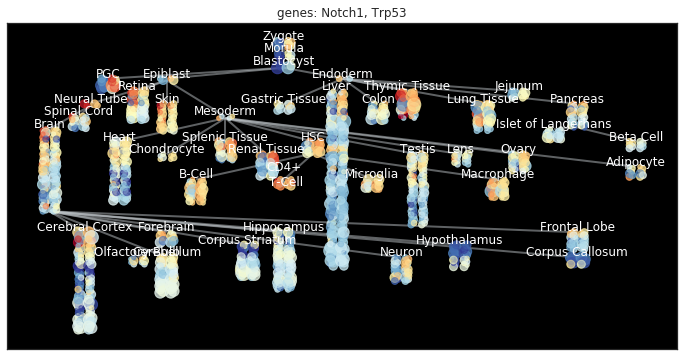

In [85]:
queryGenes=['Notch1','Trp53']
#['Trp53','Notch1']#'Idh2'#'Idh1'#'Egfr'#'Magea3'#'Mage-a',Hand1,'Sox7','Sox2' 'Nkx2-5'#'Nt5e'#'Idh1'#'Igfbp2'#'Cited1'#'Pou5f1',Notch1, Hnf1a, Mdm2, Col7a1


aspectRatio=2
size=6
fig,ax=plt.subplots(figsize=(aspectRatio*size,size))
ax.set_axis_bgcolor('black')

myCmap=mpl.cm.RdYlBu_r

nx.draw_networkx_edges( fullG,pos=myPosTuple_non_shift.to_dict(),
                        with_labels=False,
                       alpha=0.5,edge_color='#BDC3C7',width=2.0,ax=ax)
nx.draw_networkx_labels(fullG,pos=labelPosTuple,labels=simplifiedMapping.to_dict()
                        ,ax=ax,font_color='white',font_size=12)
ax.set_xticklabels([])
ax.set_yticklabels([])

X_pos_label='NODE_X_LOCATION'
myPosDf=mergedDf.set_index('Name')[[X_pos_label,'NODE_Y_LOCATION']].copy()


geneSpacing=18
nGenes=len(queryGenes)
componentWidth=(nGenes-1)*geneSpacing
meanShift=componentWidth/2
for i,queryGene in enumerate(queryGenes):
    exprS=collapseDf.loc[queryGene]/collapseDf.loc[queryGene].max()
    myI=exprS.index
    exprS.index=myI.get_level_values(0)+'_'+myI.get_level_values(1)+'_'+myI.get_level_values(2).fillna('')
    myPosTuple=myPosDf.apply(lambda S:(S.loc[X_pos_label]+i*geneSpacing-meanShift,S.loc['NODE_Y_LOCATION']),axis=1)
    #mergedDf[X_pos_label]+i*200
    nx.draw_networkx_nodes( fullG,pos=myPosTuple.to_dict(),cmap=myCmap,node_color=(exprS.loc[list(fullG.nodes())]),
                       node_size=np.log2(srpSizeS.loc[list(fullG.nodes())]+1)*20, 
                           with_labels=False,alpha=0.5,ax=ax)
    nx.draw_networkx_nodes( fullG,pos=myPosTuple.to_dict(),
                           cmap=myCmap,node_color=(exprS.loc[list(fullG.nodes())]),
                           node_size=np.log2(srpSizeS.loc[list(fullG.nodes())]+1)*20, with_labels=False,alpha=0.5,ax=ax)
ax.set_title('genes: '+', '.join(queryGenes))
clear_output()
fig.savefig(plotOutDir+'heirachy'+'_'+'_'.join(queryGenes)+'.pdf',dpi=600)